In [3]:
# 导入需要的包
import torch
import torch.nn as nn
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import copy
from torch import nn,optim
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import  SVC

# matplotlib.rcParams['font.sans-serif'] = ['SimHei']
# matplotlib.rcParams['axes.unicode_minus'] = False


In [4]:
# 定义一个函数来读取arff文件
def read_arff(file):            
    with open(file, encoding="utf-8") as f:
        header = []
        for line in f:
            if line.startswith("@attribute"):
                header.append(line.split()[1])
            elif line.startswith("@data"):
                break
        df = pd.read_csv(f, header=None)
        df.columns = header
    return df

In [5]:
# 数据有多种格式。我们将把arff文件加载到Pandas数据帧中:
train=read_arff('KDDTrain+.arff')
test=read_arff('KDDTest+.arff')
# 输出数据的shape
print(train.shape)
print(test.shape)

(125973, 42)
(22544, 42)


In [6]:
label_list=['train','test']
y_list=[train.shape[0],test.shape[0]]
x = range(len(label_list))
plt.bar(x,y_list)  # 画出训练集和测试集的数量分布柱状图
plt.xticks([index+0.2 for index in x], label_list)
plt.xlabel("数据集")
plt.ylabel('数量')

Text(0, 0.5, '数量')

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 25454 (\N{CJK UNIFIED IDEOGRAPH-636E}) missing from font(s) Arial.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) Arial.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) Arial.
  func(*args, **kwargs)


In [10]:
# 我们将把训练和测试数据合并成一个数据帧。这将给我们更多的数据来训练我们的自动编码器。我们也会重组:
df = train.append(test)
print(df.shape)
#df = df.sample(frac=1.0) # 打乱数据顺序，保证随机性
df.head(10)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
# 开始热编码操作
protocol_type_list=list(df["'protocol_type'"])
service_list=list(df["'service'"])
flag_list=list(df["'flag'"])

#将相应的非数字类型转换为数字标识即符号型数据转化为数值型数据
def find_index(x,y):
    return [i for i in range(len(y)) if y[i]==x]

#定义将源文件行中3种协议类型转换成数字标识的函数
def handleProtocol(inputlist):
    protocol_list=['tcp','udp','icmp']
    new_protocol_list=[]
    for x in inputlist:
        if x in protocol_list:
            new_protocol_list.append(find_index(x,protocol_list)[0]) # 第0维返回的是热编码
    return new_protocol_list

#定义将源文件行中70种网络服务类型转换成数字标识的函数
def handleService(inputlist):
    service_list=['aol','auth','bgp','courier','csnet_ns','ctf','daytime','discard','domain','domain_u',
                 'echo','eco_i','ecr_i','efs','exec','finger','ftp','ftp_data','gopher','harvest','hostnames',
                 'http','http_2784','http_443','http_8001','imap4','IRC','iso_tsap','klogin','kshell','ldap',
                 'link','login','mtp','name','netbios_dgm','netbios_ns','netbios_ssn','netstat','nnsp','nntp',
                 'ntp_u','other','pm_dump','pop_2','pop_3','printer','private','red_i','remote_job','rje','shell',
                 'smtp','sql_net','ssh','sunrpc','supdup','systat','telnet','tftp_u','tim_i','time','urh_i','urp_i',
                 'uucp','uucp_path','vmnet','whois','X11','Z39_50']
    new_service_list=[]
    for x in inputlist:
        if x in service_list:
            new_service_list.append(find_index(x,service_list)[0])
    return new_service_list


#定义将源文件行中11种网络连接状态转换成数字标识的函数
def handleFlag(inputlist):
    flag_list=['OTH','REJ','RSTO','RSTOS0','RSTR','S0','S1','S2','S3','SF','SH']
    new_flag_list=[]
    for x in inputlist:
        if x in flag_list:
            new_flag_list.append(find_index(x,flag_list)[0])
    return new_flag_list
 
    
    
protocol_type_list=handleProtocol(protocol_type_list)
service_list=handleService(service_list)
flag_list=handleFlag(flag_list)


# 更新'protocol_type'  'service' 'flag' 三列数据
df["'protocol_type'"]=protocol_type_list
df["'service'"]=service_list
df["'flag'"]=flag_list

# 热编码后的数据
df.head(10)

In [ ]:
df1=df.iloc[0:70000] # 前70000条用作自编码器模型的数据包含正常和不正常
df2=df.iloc[70000:]  #后70000条用做SVM的数据，包含正常和不正常

print(len(df2))
newindex=[i for i in range(0,78517)]
df2.index=pd.Series(newindex)
df2.tail(5)

In [ ]:
#  开始进行自编码器模型实验
new_columns = list(df1.columns)
new_columns[-1] = 'target'
df1.columns = new_columns
 # 无监督学习，不需要目标列
normal_df = df1[df1.target == "normal"].drop(labels='target', axis=1)  # 正常数据
print(normal_df.shape) 
anomaly_df = df1[df1.target != "normal"].drop(labels='target', axis=1)  # 异常数据
print(anomaly_df.shape)
normal_df

In [ ]:
# 标准化和最小最大化数据
z_scaler= preprocessing.StandardScaler()
normal_df=z_scaler.fit_transform(normal_df)
anomaly_df=z_scaler.fit_transform(anomaly_df)

m_scaler = preprocessing.MinMaxScaler()
normal_df = m_scaler.fit_transform(normal_df)
anomaly_df = m_scaler.fit_transform(anomaly_df)

print(normal_df)
print("#"*100)
print(anomaly_df)

In [ ]:
# 正常数据集划分为训练集、验证集、测试集
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15, # 划分比例
  random_state=1
)
val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=1
)

print(train_df.shape)  #  正常训练集数量
print(val_df.shape)   # 正常验证集数量
print(test_df.shape)  # 正常测试集数量


anomaly_df=anomaly_df.reshape(-1,1,41) # 异常测试集数量
print(anomaly_df.shape)

In [ ]:
# 将数据变成30923*1*41的形状
train_df=train_df.reshape(-1,1,41) 
val_df=val_df.reshape(-1,1,41)
test_df=test_df.reshape(-1,1,41)
print(train_df.shape)  #  正常训练集数量
print(val_df.shape)   # 正常验证集数量
print(test_df.shape)  # 正常测试集数量
print(type(train_df))

In [8]:
# 将数据转化为张量
def create_dataset(df):
  sequences = df.tolist() 
  dataset = [torch.tensor(s).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

train_dataset, seq_len, n_features = create_dataset(train_df) # 正常训练集
val_dataset, _, _ = create_dataset(val_df) # 正常验证集

test_normal_dataset, _, _ = create_dataset(test_df)  #  正常测试集
test_anomaly_dataset, _, _ = create_dataset(anomaly_df) # 异常测试集

NameError: name 'train_df' is not defined

In [9]:
# 自编码器模型
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.rnn_en1 = torch.nn.LSTM(  #41->20
            input_size=41,
            hidden_size=20,
            num_layers=1,
            batch_first=True
        )
        self.rnn_en2 = torch.nn.LSTM(  #20->10
            input_size=20,
            hidden_size=10,
            num_layers=1,
            batch_first=True
        )
        
        self.out = torch.nn.Linear(in_features=10, out_features=2) # 10->2


        self.rnn_de1 = torch.nn.LSTM(  # 2->10
            input_size=2,
            hidden_size=10,
            num_layers=1,
            batch_first=True
        )
        self.rnn_de2 = torch.nn.LSTM(  # 10->20
            input_size=10,
            hidden_size=20,
            num_layers=1,
            batch_first=True
        )
        self.out_2 = torch.nn.Linear(in_features=20, out_features=41) # 20->41
        
    def forward(self, x):
        output, (h_n, c_n) = self.rnn_en1(x) # 41->20
        output,(h_n, c_n)=self.rnn_en2(output.view(-1,1,20)) # 20->10
        encode = self.out(output) # 10->3

        output1, (h_n1, c_n1) = self.rnn_de1(encode.view(-1, 1, 2)) # 2->10
        output1,(h_n1, c_n1)=self.rnn_de2(output1.view(-1, 1, 10)) # 10->20
        decode = self.out_2(output1) # 20->41

        encode=encode.squeeze(-1)
        decode=decode.squeeze(-1)
        return encode, decode

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 模型加载
model = AutoEncoder()
model = model.to(device)

In [11]:
# 训练模型
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # 优化器
  criterion = nn.MSELoss(reduction='sum').to(device) # 损失函数使用MSE
  history = dict(train=[], val=[])  # 记录训练数据的误差损失和验证集的误差损失
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0  # 初始化最大损失
  for epoch in range(1, n_epochs + 1):
    model = model.train()  # 切换到训练模式
    train_losses = []  # 训练误差
    for seq_true in train_dataset:
      optimizer.zero_grad()  # 梯度清零
      seq_true = seq_true.to(device)
      seq_compressed,seq_pred = model(seq_true.view(-1,1,41))  # 获得压缩后的数据和还原的数据
      loss = criterion(seq_pred, seq_true.view(-1,1,41)) # 求原始数据和还原后的数据的重构误差损失
      loss.backward()  # 误差反向传播
      optimizer.step()  # 更新参数
      train_losses.append(loss.item())
    val_losses = []
    model = model.eval() # 切换到eval模式  不需要梯度更新
    with torch.no_grad():  # 不需要梯度
      for seq_true in val_dataset:  # 验证集 防止过拟合
        # seq_true=seq_true.view(-1,1,41)
        seq_true = seq_true.to(device)
        _,seq_pred = model(seq_true.view(-1,1,41))
        loss = criterion(seq_pred, seq_true.view(-1,1,41))  # 验证集误差
        val_losses.append(loss.item())
    train_loss = np.mean(train_losses) # 取误差平均
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)
    if val_loss < best_loss: # 更新损失误差
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [12]:
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=100
)

NameError: name 'train_dataset' is not defined

In [13]:
# 加载训练好的模型
model = torch.load('LSTM_2020_6_1_two_dimensions.pth')
model = model.to(device)

FileNotFoundError: [Errno 2] No such file or directory: 'LSTM_2020_6_1_two_dimensions.pth'

In [ ]:
model.eval()

In [14]:
#  随着训练次数的增加 train_loss和val_loss的分布情况，曲线大致相近
x=[i for i in range(1,101)]
y1=history['train']
y2=history['val']

plt.plot(x, y1, label='train_loss')
plt.plot(x, y2, label='val_loss')
plt.legend()
plt.show()  # 画出训练集和验证集的误差损失分布


NameError: name 'history' is not defined

In [15]:
# # # 保存模型
# MODEL_PATH = 'LSTM_2020_6_1_two_dimensions.pth'
# torch.save(model, MODEL_PATH)

In [16]:
# 用训练好的模型来预测
def predict(model, dataset):
  compressed,predictions, losses = [], [],[]
  criterion = nn.MSELoss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true=seq_true.view(-1,1,41)
      seq_true = seq_true.to(device)
      seq_compressed,seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      predictions.append(seq_pred.cpu().numpy().flatten())
      compressed.append(seq_compressed.cpu().numpy().flatten())
      losses.append(loss.item())
  return  compressed,predictions, losses

In [17]:
# 绘制正常训练集重构损失核函数图
_,_, losses = predict(model, train_dataset)
sns.distplot(losses, bins=50, kde=True);

NameError: name 'train_dataset' is not defined

In [18]:
# 绘制正常测试集重构损失核函数图  
_,predictions, pred_losses1 = predict(model, test_normal_dataset)
sns.distplot(pred_losses1, bins=50, kde=True);

NameError: name 'test_normal_dataset' is not defined

In [19]:
# 输出训练集  测试集损失误差的平均值
print(np.mean(losses))
print(np.mean(pred_losses1))

NameError: name 'losses' is not defined

In [20]:
# 验证异常测试数据  
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]  # 选择和正常测试集一样的数据量
_,predictions, pred_losses2 = predict(model, anomaly_dataset)
sns.distplot(pred_losses2, bins=50, kde=True)

NameError: name 'test_anomaly_dataset' is not defined

In [21]:
# 将正常数据测试集和异常数据测试集的误差分布放到一个图中
recon_err_test_normal = pred_losses1
recon_err_test_anomaly = pred_losses2
sns.kdeplot(recon_err_test_normal,shade=True)
sns.kdeplot(recon_err_test_anomaly,shade=True)
plt.show()

NameError: name 'pred_losses1' is not defined

In [22]:
threshold_range=np.linspace(0,8,1000) # 根据上图将可能取到的阈值区间划分为1000份
correct_rate_test_noraml=0
correct_rate_test_anomaly=0
acc_list=[]
rate_normal=[]
rate_anomaly=[]
for t in threshold_range:  # 计算不同阈值下正常数据被判断正确的概率和异常数据被判断正确的概率
    correct_rate_test_noraml=(sum(l <= t for l in pred_losses1)/len(test_normal_dataset))
    correct_rate_test_anomaly=(sum(l > t for l in pred_losses2)/len(test_normal_dataset))
    rate_normal.append(correct_rate_test_noraml)
    rate_anomaly.append(correct_rate_test_anomaly)

    
plt.plot(threshold_range, rate_normal, label='accuracy_normal')
plt.plot(threshold_range, rate_anomaly, label='accuracy_anomaly')
plt.legend()
plt.show()
plt.savefig("6.svg")


NameError: name 'pred_losses1' is not defined

In [23]:
df2 # 再用df2来检测以下我们的的自编码器模型

NameError: name 'df2' is not defined

In [24]:
X_NormalAndAnomaly=df2.iloc[:,0:-1]  #  取除了label外的列
Y_NormalAndAnomaly=df2.iloc[:,-1]    #  只取label列

z_scaler= preprocessing.StandardScaler()  # 标准化
X_NormalAndAnomaly=z_scaler.fit_transform(X_NormalAndAnomaly)


m_scaler = preprocessing.MinMaxScaler()  # 最大最小化
X_NormalAndAnomaly = m_scaler.fit_transform(X_NormalAndAnomaly)


NameError: name 'df2' is not defined

In [25]:
X_NormalAndAnomaly=X_NormalAndAnomaly.reshape(-1,1,41) # 改变形状适应模型的input_size
X_NormalAndAnomaly,_,_= create_dataset(X_NormalAndAnomaly )

NameError: name 'X_NormalAndAnomaly' is not defined

In [26]:
_,_, losses = predict(model, X_NormalAndAnomaly)  # losses中包含了正常数据的重构误差也包含了异常数据的重构误差

NameError: name 'X_NormalAndAnomaly' is not defined

In [27]:

real_normal_count=0
real_anomal_count=0
y=[]
Y_NormalAndAnomaly
for i in range(0,len(Y_NormalAndAnomaly)):
    y.append(Y_NormalAndAnomaly[i])
    #print(Y_NormalAndAnomaly[i])
    if Y_NormalAndAnomaly[i]=="normal":
        real_normal_count=real_normal_count+1
    if Y_NormalAndAnomaly[i]=="anomaly":
        real_anomal_count=real_anomal_count+1
print(real_normal_count)   # df2中正常数据的数量
print(real_anomal_count)  # df2中异常数据的数量


NameError: name 'Y_NormalAndAnomaly' is not defined

In [28]:
FPR=[]
TPR=[]
labels=y
threshold_range=np.linspace(0.1,12,1000)  #  阈值区间划分
for t in threshold_range:
    judge=[]
#     print(t)
    for i in range(0,len(losses)):
        if losses[i]<=t:
            judge.append("normal")
        else:
            judge.append("anomaly")
    TP=0
    TN=0
    FP=0
    FN=0
    #print(judge[0:100])
    for x1,y1 in zip(labels,judge):
        if x1=="normal" and y1=="normal":
            TP=TP+1
        elif x1=="anomaly" and y1=="anomaly":
            TN=TN+1
        elif x1=="normal" and y1=="anomaly":
            FN=FN+1
        elif x1=="anomaly" and y1=="normal":
            FP=FP+1
      
    TPR.append(TP/(TP+FN)) # 预测为正且实际为正的样本占所有正例样本的比例。
    FPR.append(FP/(FP+TN)) # 预测为正但实际为负的样本占所有负例样本的比例
    
            
    

NameError: name 'losses' is not defined

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

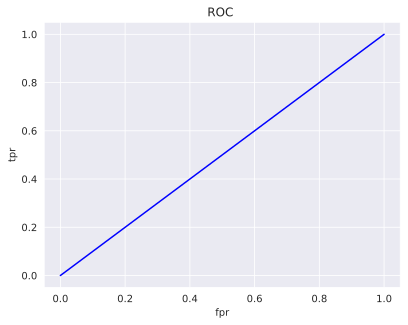

<Figure size 640x480 with 0 Axes>

In [29]:
plt.title('ROC ')  # 绘制ROC曲线  横轴为fpr  纵轴为tpr
x1=np.linspace(0,1,1000)
y1=np.linspace(0,1,1000)
plt.plot(FPR,TPR,color="red")
plt.plot(x1,y1,color="blue")
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()
plt.savefig("7.svg")

In [30]:
# ROC曲线中离（0，1）点最近的点所代表的阈值是分类效果最好的 为求得这个阈值 可以用ROC曲线上面的点到
# 直线y=x这条直线上的距离来反映  距离越大  阈值对于二分类的效果就越好
dis=0
i=-1
maxIndex=-1
for x_fpr,y_tpr in zip(FPR,TPR):
    i=i+1
    newDis=np.abs(x_fpr*1-y_tpr*1+0)/np.sqrt(4)
    if newDis>dis:
        dis=newDis
        maxIndex=i
        
threshold_range[maxIndex]    

12.0

In [31]:
THRESHOLD=threshold_range[maxIndex]   # 最佳阈值

In [32]:
# 正常测试集的准确率
correct = sum(l <= THRESHOLD for l in pred_losses1)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')
print('Accuracy:',(correct/len(test_normal_dataset)))

NameError: name 'pred_losses1' is not defined

In [33]:
# 异常常测试集的准确率
correct = sum(l >= THRESHOLD for l in pred_losses2)
print(f'Correct anormaly predictions: {correct}/{len(anomaly_dataset)}')
print('Accuracy:',(correct/len(anomaly_dataset)))

NameError: name 'pred_losses2' is not defined

In [34]:
# df2（正常异常混合数据）的检测准确率
normal_num=0
anomaly_num=0
detect_ans=[]
for i in range(0,len(losses)):
    if losses[i]<=THRESHOLD:
        detect_ans.append("normal")
        if y[i]=="normal":
              normal_num=normal_num+1
        #print("正常:",i)
     
    if losses[i]>THRESHOLD:
        detect_ans.append("anomaly")
        if y[i]!="normal":
            anomaly_num=anomaly_num+1
       # print("异常:",i)

print(normal_num,"/",real_normal_count)   
print("正常数据检测准确率",normal_num/real_normal_count)
print(anomaly_num,"/",real_anomal_count)
print("异常数据检测准确率",anomaly_num/real_anomal_count)

NameError: name 'losses' is not defined

In [35]:
# 将预测结果以DataFrame的形式展现
loss=losses
thresholdlist=[THRESHOLD for i in range(0,len(loss))]
labels=y
judge=detect_ans
TF_state=[]
for x1,y1 in zip(labels,judge):
    if x1==y1:
        TF_state.append("√")
    else:
        TF_state.append("×")
data={"loss":loss,"threshold":thresholdlist,"predict":judge,"labels":labels,"T/F?":TF_state}
result=pd.DataFrame(data)
result.head(50)

NameError: name 'losses' is not defined

In [36]:
# 对于df2数据计算准确率、精确率、召回率、f1分数这四个指标
TP=0
TN=0
FP=0
FN=0
thread_range=np.linspace(0,12,1000)
for x,y in zip(labels,judge):
    if x==y:
        if x=="normal":
            TP=TP+1
        else:
            TN=TN+1
    else:
        if x=="normal":  # 把正常的判断成了不正常的
            FP=FP+1
        else:   # 把不正常的判断成了正常的
            FN=FN+1  

accuracy=(TP+TN)/(TP+TN+FP+FN)  # 准确率  所有的预测正确（正类负类）的占总的比重
precision=TP/(TP+FP)  #  精确率  预测为正样本的结果中，我们有多少把握可以预测正确
recall=TP/(TP+FN)   # 召回率  在实际为正的样本中被预测为正样本的概率
f1=(2*TP)/(2*TP+FP+FN)
print("准确率:",accuracy)
print("精确率:",precision)
print("召回率:",recall)
print("f1分数:",f1)


ZeroDivisionError: division by zero

In [ ]:
# 实验第2部分使用SVM进行分类
df2

In [37]:
from sklearn.model_selection import train_test_split
# 训练集测试集分割
X_train,X_test,y_train,y_test=train_test_split(df2.loc[:,df2.columns!="'class'"],df2["'class'"],stratify=df2["'class'"],random_state=66)

NameError: name 'df2' is not defined

In [38]:
# 将label离散数值（normal anomaly）转化成数字0 1
y_train_list_compress=y_train.to_list()
y_train_label_compress=[0 if y_train_list_compress[i]=="normal" else 1 for i in range(0,len(y_train_list_compress))]

NameError: name 'y_train' is not defined

In [39]:
# 输出训练集测试集的形状
print(X_train.shape,"  ",type(X_train))
print(X_test.shape,"  ",type(X_test))
print(y_train.shape,"  ",type(y_train))
print(y_test.shape,"  ",type(y_test))
X_train

NameError: name 'X_train' is not defined

In [40]:
from sklearn import preprocessing
z_scaler= preprocessing.StandardScaler()
X_train_scaler=z_scaler.fit_transform(X_train)
X_test_scaler=z_scaler.fit_transform(X_test)

m_scaler = preprocessing.MinMaxScaler()
X_train_scaler = m_scaler.fit_transform(X_train_scaler) 
X_test_scaler=m_scaler.fit_transform(X_test_scaler)
# 标准化  最大化最小化数据

NameError: name 'X_train' is not defined

In [41]:
X_train_scaler=X_train_scaler.reshape(58887,1,41) # 使得输入的数据形状适合模型的input_size
X_test_scaler=X_test_scaler.reshape(19630,1,41)
X_train_scaler,_,_=create_dataset(X_train_scaler)
X_test_scaler,_,_=create_dataset(X_test_scaler)

NameError: name 'X_train_scaler' is not defined

In [42]:
# 使用模型获得压缩后的训练数据和测试数据
X_train_scaler_compressed,_,_=predict(model,X_train_scaler)
X_test_scaler_compressed,_,_=predict(model,X_test_scaler)

NameError: name 'X_train_scaler' is not defined

In [43]:
# SVM使用核函数为rbf 
from sklearn.svm import  SVC
svc=SVC(C=0.85, kernel='rbf', degree=3)
svc.fit(X_train_scaler_compressed,y_train)
print("训练集准确率： ",svc.score(X_train_scaler_compressed,y_train))
print("测试集准确率： ",svc.score(X_test_scaler_compressed,y_test))

NameError: name 'X_train_scaler_compressed' is not defined

In [44]:
judge=svc.predict(X_test_scaler_compressed) # 预测的标签
labels=y_test # 实际标签

NameError: name 'X_test_scaler_compressed' is not defined

In [45]:
TP=0
TN=0
FP=0
FN=0
thread_range=np.linspace(0,12,1000)
for x,y in zip(labels,judge):
    if x==y:
        if x=="normal":
            TP=TP+1
        else:
            TN=TN+1
    else:
        if x=="normal":  # 把正常的判断成了不正常的
            FP=FP+1
        else:   # 把不正常的判断成了正常的
            FN=FN+1  

accuracy=(TP+TN)/(TP+TN+FP+FN)  # 准确率  所有的预测正确（正类负类）的占总的比重
precision=TP/(TP+FP)  #  精确率  预测为正样本的结果中，我们有多少把握可以预测正确
recall=TP/(TP+FN)   # 召回率  在实际为正的样本中被预测为正样本的概率
f1=(2*TP)/(2*TP+FP+FN)
print("准确率:",accuracy)
print("精确率:",precision)
print("召回率:",recall)
print("f1分数:",f1)


ZeroDivisionError: division by zero

In [46]:
# SVM使用核函数为linear
svc=SVC(C=0.85, kernel='linear', degree=3)
svc.fit(X_train_scaler_compressed,y_train)
print("训练集准确率： ",svc.score(X_train_scaler_compressed,y_train))
print("测试集准确率： ",svc.score(X_test_scaler_compressed,y_test))

NameError: name 'X_train_scaler_compressed' is not defined

In [47]:
# SVM使用核函数为poly
svc=SVC(C=0.85, kernel='poly', degree=3)
svc.fit(X_train_scaler_compressed,y_train)
print("训练集准确率： ",svc.score(X_train_scaler_compressed,y_train))
print("测试集准确率： ",svc.score(X_test_scaler_compressed,y_test))

NameError: name 'X_train_scaler_compressed' is not defined

In [48]:
# SVM使用核函数为sigmoid
svc=SVC(C=0.85, kernel='sigmoid', degree=3)
svc.fit(X_train_scaler_compressed,y_train)
print("训练集准确率： ",svc.score(X_train_scaler_compressed,y_train))
print("测试集准确率： ",svc.score(X_test_scaler_compressed,y_test))

NameError: name 'X_train_scaler_compressed' is not defined

In [49]:
y_train=np.array(y_train)
a_list=[a[0] for a in X_train_scaler_compressed[0:2000] ]
b_list=[b[1] for b in X_train_scaler_compressed[0:2000]]
for i in range(2000):
    if y_train[i]=="normal":
        plt.scatter(a_list[i],b_list[i],c="r")
    else:
        plt.scatter(a_list[i],b_list[i],c="b")
        

NameError: name 'y_train' is not defined

In [50]:
from mpl_toolkits.mplot3d import Axes3D
##用于可视化图表
import matplotlib.pyplot as plt
##用于做科学计算
import numpy as np
##用于做数据分析
import pandas as pd
##用于加载数据或生成数据等
from sklearn import datasets
##导入PCA库
from sklearn.decomposition import PCA
##导入LDA库
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [51]:
X_train,X_test,y_train,y_test=train_test_split(df2.loc[:,df2.columns!="'class'"],df2["'class'"],stratify=df2["'class'"],random_state=66)
z_scaler= preprocessing.StandardScaler()
X_train_scaler=z_scaler.fit_transform(X_train)
X_test_scaler=z_scaler.fit_transform(X_test)

m_scaler = preprocessing.MinMaxScaler()
X_train_scaler = m_scaler.fit_transform(X_train_scaler) 
X_test_scaler=m_scaler.fit_transform(X_test_scaler)
X_train
# 标准化  最大化最小化数据

NameError: name 'df2' is not defined

In [52]:
# 将label离散数值（normal anomaly）转化成数字0 1
y_train_list_pca=y_train.to_list()
y_train_label_pca=[0 if y_train_list_pca[i]=="normal" else 1 for i in range(0,len(y_train_list_pca))]

NameError: name 'y_train' is not defined

In [53]:
# 加载PCA模型并训练、降到3维
model_pca = PCA(n_components=2)
X_train_pca = model_pca.fit(X_train_scaler).transform(X_train_scaler)
X_test_pca = model_pca.fit(X_test_scaler).transform(X_test_scaler)

NameError: name 'X_train_scaler' is not defined

In [54]:
# SVM使用核函数为rbf 
svc=SVC(C=0.85, kernel='rbf', degree=3)
svc.fit(X_train_pca,y_train)
print("训练集准确率： ",svc.score(X_train_pca,y_train))
print("测试集准确率： ",svc.score(X_test_pca,y_test))

NameError: name 'X_train_pca' is not defined

In [55]:
judge=svc.predict(X_test_pca) # 预测的标签
labels=y_test # 实际标签

NameError: name 'X_test_pca' is not defined

In [56]:
TP=0
TN=0
FP=0
FN=0
thread_range=np.linspace(0,12,1000)
for x,y in zip(labels,judge):
    if x==y:
        if x=="normal":
            TP=TP+1
        else:
            TN=TN+1
    else:
        if x=="normal":  # 把正常的判断成了不正常的
            FP=FP+1
        else:   # 把不正常的判断成了正常的
            FN=FN+1  

accuracy=(TP+TN)/(TP+TN+FP+FN)  # 准确率  所有的预测正确（正类负类）的占总的比重
precision=TP/(TP+FP)  #  精确率  预测为正样本的结果中，我们有多少把握可以预测正确
recall=TP/(TP+FN)   # 召回率  在实际为正的样本中被预测为正样本的概率
f1=(2*TP)/(2*TP+FP+FN)
print("准确率:",accuracy)
print("精确率:",precision)
print("召回率:",recall)
print("f1分数:",f1)


ZeroDivisionError: division by zero

In [ ]:
# SVM使用核函数为linear
svc=SVC(C=0.85, kernel='linear', degree=3)
svc.fit(X_train_pca,y_train)
print("训练集准确率： ",svc.score(X_train_pca,y_train))
print("测试集准确率： ",svc.score(X_test_pca,y_test))

In [57]:
# SVM使用核函数为poly
svc=SVC(C=0.85, kernel='poly', degree=3)
svc.fit(X_train_pca,y_train)
print("训练集准确率： ",svc.score(X_train_pca,y_train))
print("测试集准确率： ",svc.score(X_test_pca,y_test))

NameError: name 'X_train_pca' is not defined

In [58]:
# SVM使用核函数为sigmoid
svc=SVC(C=0.85, kernel='sigmoid', degree=3)
svc.fit(X_train_pca,y_train)
print("训练集准确率： ",svc.score(X_train_pca,y_train))
print("测试集准确率： ",svc.score(X_test_pca,y_test))

NameError: name 'X_train_pca' is not defined

In [59]:
y_train=np.array(y_train)
a_list=[a[0] for a in X_train_pca[0:2000] ]
b_list=[b[1] for b in X_train_pca[0:2000]]
for i in range(2000):
    if y_train[i]=="normal":
        plt.scatter(a_list[i],b_list[i],c="r")
    else:
        plt.scatter(a_list[i],b_list[i],c="b")

NameError: name 'y_train' is not defined